In [2]:
%pip install s3fs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.6/179.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 11.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.6.1 requires fsspec==2024.6.1, but you have fsspec 2024.10.0 which is incompatible.


In [3]:
import pandas as pd
from sklearn.mixture import BayesianGaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from google.colab import userdata
import os
import s3fs
import numpy as np
import requests
import gzip
import shutil
import time
import os
import logging
import sys
import os.path
from tqdm.notebook import tqdm
from io import BytesIO
import matplotlib.pyplot as plt
import json
import math
from sklearn.metrics import silhouette_score

## Download files

In [41]:
S3_BUCKET_URL = "https://vcthackathon-data.s3.us-west-2.amazonaws.com"

# (game-changers, vct-international, vct-challengers)
LEAGUE = "game-changers"

# (2022, 2023, 2024)
YEAR = 2024

In [42]:
def download_gzip_and_write_to_json(file_name):
    if os.path.isfile(f"{file_name}.json"):
        return False

    remote_file = f"{S3_BUCKET_URL}/{file_name}.json.gz"
    response = requests.get(remote_file, stream=True)

    if response.status_code == 200:
        gzip_bytes = BytesIO(response.content)
        with gzip.GzipFile(fileobj=gzip_bytes, mode="rb") as gzipped_file:
            with open(f"{file_name}.json", 'wb') as output_file:
                shutil.copyfileobj(gzipped_file, output_file)
        return True
    elif response.status_code == 404:
        # Ignore
        return False
    else:
        print(response)
        print(f"Failed to download {file_name}")
        return False


def download_esports_files():
    print(f"Downloading esports files for {LEAGUE}...")
    directory = f"{LEAGUE}/esports-data"

    if not os.path.exists(directory):
        os.makedirs(directory)

    esports_data_files = ["leagues", "tournaments",
                          "players", "teams", "mapping_data"]
    for file_name in tqdm(esports_data_files):
        download_gzip_and_write_to_json(f"{directory}/{file_name}")

    print("Done downloading esports files")

In [43]:
download_esports_files()

  0%|          | 0/5 [00:00<?, ?it/s]

Done downloading esports files


In [44]:
with open(f'/content/{LEAGUE}/esports-data/players.json', 'r') as f:
    player_df = pd.DataFrame(json.load(f))

with open(f'/content/{LEAGUE}/esports-data/mapping_data.json', 'r') as f:
    mapping_df = pd.DataFrame(json.load(f))

with open(f'/content/{LEAGUE}/esports-data/teams.json', 'r') as f:
    team_df = pd.DataFrame(json.load(f))

with open(f'/content/{LEAGUE}/esports-data/tournaments.json', 'r') as f:
    tournament_df = pd.DataFrame(json.load(f))

with open(f'/content/{LEAGUE}/esports-data/leagues.json', 'r') as f:
    league_df = pd.DataFrame(json.load(f))

In [45]:
player_df.head()

id    handle first_name last_name  status  \
0  107025876564296044      Toma      Tommi  Lehtinen  active   
1  106977714184829995  Stefanie   Stefanie     Jones  active   
2  107176790303905255      aRth     Arthur   Hardman  active   
3  107282855606202828   godwana     Engin      Balcı  active   
4  106977742188901804    Jaxsen    Jackson   Popelka  active   

                                           photo_url        home_team_id  \
0  http://static.lolesports.com/players/163303303...  106652238530500027   
1  http://static.lolesports.com/players/163235037...  106976771652907805   
2                                               None  107174817570297246   
3  http://static.lolesports.com/players/163700646...  107021298845350518   
4  http://static.lolesports.com/players/163235080...  106976774374552352   

             created_at            updated_at  
0  2021-10-01T11:19:00Z  2021-10-01T11:19:00Z  
1  2021-09-22T22:41:26Z  2023-04-09T14:50:55Z  
2  2021-10-28T14:16:57Z  2021-11-01T13:52:31Z  
3  2021-11-15T21:00:23Z  2023-05-29T08:05:32Z  
4  2021-09-22T22:49:42Z  2021-09-22T22:49:42Z

In [46]:
mapping_df.head()

platformGameId       esportsGameId  \
0  val:a02b939b-d53b-4d6c-9cf9-8df5cbecdec6  110614988238486652   
1  val:865eb670-8fd8-4245-97b3-44540e321f8e  110780564307690152   
2  val:4d834f45-c9db-42fa-ae55-e8afd451e434  109879965968343855   
3  val:178e8b84-61fa-4a14-835d-8f0e0af83466  111006223833455227   
4  val:03bdf51f-453c-4fab-9406-63beee427e6d  109879965968475071   

         tournamentId                                        teamMapping  \
0  110614878961138673  {'18': '107185970379663407', '19': '1082407634...   
1  110780564306117263  {'18': '110745562660975168', '19': '1087481697...   
2  109879965964411657  {'17': '108452390946539707', '18': '1076008816...   
3  111006194588670534  {'19': '108748177717149112', '20': '1110572219...   
4  109879965964411657  {'17': '108172266878972669', '18': '1098798864...   

                                  participantMapping  
0  {'1': '110196391536301033', '2': '108550500823...  
1  {'1': '108748099637064824', '2': '108748093351...  
2  {'1': '107600796790972557', '2': '107600798796...  
3  {'1': '111067926063836716', '2': '111067931077...  
4  {'1': '107897747787068260', '2': '107910792460...

In [47]:
team_df.head()

id acronym      home_league_id  \
0  111006711389612074      LH  109029777807406730   
1  109029888698112406     LWE  109029777807406730   
2  112439820691490172     MIR  109029777807406730   
3  112439825505751243     STG  109029777807406730   
4  112439841344832900     PIX  109029777807406730   

                                       dark_logo_url  \
0  http://static.lolesports.com/teams/16938279917...   
1  http://static.lolesports.com/teams/16636640700...   
2  http://static.lolesports.com/teams/17218115286...   
3                                               None   
4                                               None   

                                      light_logo_url               slug  \
0  http://static.lolesports.com/teams/16938279917...    lunatichai-flax   
1  http://static.lolesports.com/teams/16636640700...   lone-way-esports   
2  http://static.lolesports.com/teams/17218115286...         mir-gaming   
3  http://static.lolesports.com/teams/17156955705...  special-tigers-gc   
4  http://static.lolesports.com/teams/17156958114...              pixel   

                name  
0   Lunatic-hai flax  
1  Lone Way E-SPORTS  
2         MIR Gaming  
3  Special TiGers GC  
4              Pixel

In [48]:
tournament_df.head()

id     status           league_id          time_zone  \
0  107175003635964716  published  106375817979489820            Etc/UTC   
1  108490384940728464  published  106375817979489820            Etc/UTC   
2  111007250890578805  published  106375817979489820  America/Sao_Paulo   
3  112787120263393743  published  106375817979489820    Europe/Sarajevo   
4  109134639255397767  published  106375817979489820            Etc/UTC   

                            name  
0                       stage_02  
1            game_changers_br_s1  
2          game_changers_br_2023  
3  game_changers_br_stage_2_2024  
4                     gc_etapa_2

In [49]:
league_df.head()

league_id region  \
0  109029777807406730     KR   
1  112609302000026507   INTL   
2  108752229027041361     JP   
3  106375817979489820     BR   
4  109879575186437267  LATAM   

                                       dark_logo_url  \
0  http://static.lolesports.com/leagues/166366237...   
1  http://static.lolesports.com/leagues/171828157...   
2  http://static.lolesports.com/leagues/165942731...   
3  http://static.lolesports.com/leagues/logo-gc-p...   
4  http://static.lolesports.com/leagues/167662925...   

                                      light_logo_url  \
0  http://static.lolesports.com/leagues/166366237...   
1  http://static.lolesports.com/leagues/171828157...   
2  http://static.lolesports.com/leagues/165942731...   
3  http://static.lolesports.com/leagues/logo-gc-p...   
4  http://static.lolesports.com/leagues/167662925...   

                          name                         slug  
0             game_changers_kr             game_changers_kr  
1             game_changers_sa             game_changers_sa  
2            game_changers_jpn            game_changers_jpn  
3  game_changers_series_brazil  game_changers_series_brazil  
4          game_changers_latam          game_changers_latam

## Data Science

In [50]:
os.environ['AWS_ACCESS_KEY_ID'] = userdata.get('aws_access_key_id')
os.environ['AWS_SECRET_ACCESS_KEY'] = userdata.get('aws_secret_access_key')
os.environ['AWS_DEFAULT_REGION'] = 'us-west-2'

In [51]:
s3 = s3fs.S3FileSystem(anon=False)
s3_path = f's3://actualvctdata/{LEAGUE}/parquet/{YEAR}.parquet/'
parquet_files = [file for file in s3.glob(s3_path + '*.parquet')]
df = pd.concat([pd.read_parquet(f's3://{file}') for file in parquet_files])
df.head()

ROUND_NUMBER  OUTCOME  SIDE  KILLS  DEATHS  ASSISTS  COMBAT_SCORE  \
0           1.0      1.0  -1.0    1.0     0.0      0.0         230.0   
1           1.0      1.0  -1.0    2.0     0.0      1.0         354.0   
2           1.0      1.0  -1.0    1.0     1.0      0.0         250.0   
3           1.0      1.0  -1.0    1.0     1.0      0.0         234.0   
4           1.0      1.0  -1.0    0.0     0.0      1.0          56.0   

   KILLS_STINGER  KILLS_BUCKY  KILLS_JUDGE  ...  YORU_PICK_RATE  \
0            0.0          0.0          0.0  ...             0.0   
1            0.0          0.0          0.0  ...             0.0   
2            0.0          0.0          0.0  ...             0.0   
3            0.0          0.0          0.0  ...             0.0   
4            0.0          0.0          0.0  ...             0.0   

   ISO_PICK_RATE  CLOVE_PICK_RATE  VYSE_PICK_RATE  DUELIST_PICK_RATE  \
0            0.0              0.0             0.0                0.0   
1            0.0              0.0             0.0                0.0   
2            0.0              0.0             0.0                0.0   
3            0.0              0.0             0.0                1.0   
4            0.0              0.0             0.0                0.0   

   INITIATOR_PICK_RATE  SENTINEL_PICK_RATE  CONTROLLER_PICK_RATE  \
0                  1.0                 0.0                   0.0   
1                  1.0                 0.0                   0.0   
2                  0.0                 0.0                   1.0   
3                  0.0                 0.0                   0.0   
4                  0.0                 1.0                   0.0   

                   id                                           metadata  
0  110196509462001155  {map=LOTUS, game_id=val:00d5b763-f082-481f-8d7...  
1  107025876838906695  {map=LOTUS, game_id=val:00d5b763-f082-481f-8d7...  
2  110196607873067874  {map=LOTUS, game_id=val:00d5b763-f082-481f-8d7...  
3  110196702294187829  {map=LOTUS, game_id=val:00d5b763-f082-481f-8d7...  
4  110196647859540239  {map=LOTUS, game_id=val:00d5b763-f082-481f-8d7...  

[5 rows x 63 columns]

In [52]:
df.head()
df.to_pickle(f'/content/{LEAGUE}-{YEAR}-df.pkl')

In [53]:
stripped_meta_df = df.loc[:, ~df.columns.isin(['metadata'])]
agg_df = stripped_meta_df.groupby('id').agg({
    'ROUND_NUMBER': 'max',
    **{col: 'mean' for col in stripped_meta_df.columns if col not in ['id', 'ROUND_NUMBER']}
})
drop_cols = ['OUTCOME', 'COMBAT_SCORE', 'KILLS', 'CONTROLLER_PICK_RATE', 'SENTINEL_PICK_RATE', 'INITIATOR_PICK_RATE', 'DUELIST_PICK_RATE']
for col in drop_cols:
    agg_df = agg_df.drop(col, axis=1)
pt = PowerTransformer(copy=False)
pt.fit_transform(agg_df)
agg_df.to_pickle(f'/content/{LEAGUE}-{YEAR}-agg.pkl')
print(agg_df.info())
agg_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 347 entries, - to 112891299631595293
Data columns (total 54 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ROUND_NUMBER         347 non-null    float64
 1   SIDE                 347 non-null    float64
 2   DEATHS               347 non-null    float64
 3   ASSISTS              347 non-null    float64
 4   KILLS_STINGER        347 non-null    float64
 5   KILLS_BUCKY          347 non-null    float64
 6   KILLS_JUDGE          347 non-null    float64
 7   KILLS_SPECTRE        347 non-null    float64
 8   KILLS_BULLDOG        347 non-null    float64
 9   KILLS_GUARDIAN       347 non-null    float64
 10  KILLS_PHANTOM        347 non-null    float64
 11  KILLS_VANDAL         347 non-null    float64
 12  KILLS_MARSHAL        347 non-null    float64
 13  KILLS_OUTLAW         347 non-null    float64
 14  KILLS_OPERATOR       347 non-null    float64
 15  KILLS_ARES           347 non-n

ROUND_NUMBER      SIDE    DEATHS   ASSISTS  KILLS_STINGER  \
id                                                                              
-                      -2.416376 -4.232835 -2.230480  0.726859      -0.770870   
106371570922864110      0.740826 -0.450660 -0.809343  0.791967      -0.770870   
106371572811742769      1.363058 -0.605352 -0.519918  0.184979       0.963865   
106371583096241717      0.132270 -0.251934 -0.674601  0.479166       0.836918   
106371585325121013     -0.753410 -3.218659 -0.484139 -1.665384      -0.770870   

                    KILLS_BUCKY  KILLS_JUDGE  KILLS_SPECTRE  KILLS_BULLDOG  \
id                                                                           
-                     -0.364931    -0.524846      -1.061927       2.602302   
106371570922864110    -0.364931    -0.524846       0.371144      -0.929466   
106371572811742769    -0.364931    -0.524846      -0.575765       0.676827   
106371583096241717    -0.364931    -0.524846       0.951732      -0.122018   
106371585325121013    -0.364931    -0.524846      -1.061927      -1.451732   

                    KILLS_GUARDIAN  ...  RAZE_PICK_RATE  REYNA_PICK_RATE  \
id                                  ...                                    
-                        -1.237198  ...       -0.518179        -0.246961   
106371570922864110       -1.237198  ...       -0.518179        -0.246961   
106371572811742769       -0.845262  ...       -0.518179        -0.246961   
106371583096241717       -1.237198  ...       -0.518179        -0.246961   
106371585325121013        0.402176  ...       -0.518179        -0.246961   

                    SAGE_PICK_RATE  SKYE_PICK_RATE  SOVA_PICK_RATE  \
id                                                                   
-                        -0.276105       -0.450332        1.915715   
106371570922864110       -0.276105       -0.450332        1.789826   
106371572811742769       -0.276105       -0.450332        1.590935   
106371583096241717       -0.276105       -0.450332        1.778474   
106371585325121013       -0.276105       -0.450332        1.890900   

                    VIPER_PICK_RATE  YORU_PICK_RATE  ISO_PICK_RATE  \
id                                                                   
-                         -0.660963       -0.257586      -0.178576   
106371570922864110        -0.660963       -0.257586      -0.178576   
106371572811742769         1.619483       -0.257586      -0.178576   
106371583096241717         0.658654       -0.257586      -0.178576   
106371585325121013        -0.660963       -0.257586      -0.178576   

                    CLOVE_PICK_RATE  VYSE_PICK_RATE  
id                                                   
-                          -0.23074             0.0  
106371570922864110         -0.23074             0.0  
106371572811742769         -0.23074             0.0  
106371583096241717         -0.23074             0.0  
106371585325121013         -0.23074             0.0  

[5 rows x 54 columns]

In [14]:
agg_df = pd.read_pickle(f'/content/{LEAGUE}-{YEAR}-agg.pkl')

In [54]:
from sklearn import metrics
import pickle
X = agg_df.to_numpy()
print(X.shape)
bgmm = BayesianGaussianMixture(covariance_type='full',
                                  n_components=5,
                                  n_init = 100)
prop = bgmm.fit_predict(X)
bay_gmm_weights = bgmm.weights_

with open(f'/content/{LEAGUE}-{YEAR}-bggm.pkl','wb') as f:
    pickle.dump(bgmm,f)

print(np.round(bay_gmm_weights,2))
print(silhouette_score(X, prop))
print(prop)
metrics.calinski_harabasz_score(X, prop)

(347, 54)
[0.01 0.25 0.49 0.21 0.05]
0.06676008005558354
[2 2 2 2 2 2 2 1 3 3 2 2 4 2 2 2 2 2 2 3 4 2 2 2 2 2 3 2 2 2 1 2 3 2 2 2 2
 2 3 2 2 3 3 1 2 2 3 2 1 2 3 2 2 4 2 2 1 2 2 3 2 2 2 2 3 2 2 1 1 2 4 2 4 3
 2 3 2 2 2 2 2 2 2 2 3 2 2 2 1 2 2 2 2 3 1 2 1 3 2 3 1 1 3 1 2 1 2 1 4 2 1
 2 2 2 2 2 2 2 2 3 2 3 2 3 1 1 1 2 2 1 1 2 2 0 2 3 2 1 2 2 4 2 3 4 2 3 1 2
 2 4 2 2 2 2 1 2 2 2 2 1 2 1 1 3 2 3 3 1 2 1 3 2 4 3 1 3 1 2 2 4 2 2 2 2 3
 1 2 1 2 3 2 2 4 2 3 2 3 2 2 2 1 3 1 2 2 2 3 2 3 3 2 1 3 2 3 4 3 2 2 3 1 1
 2 2 2 3 1 2 3 2 2 3 1 1 3 1 3 1 1 3 3 2 3 2 2 3 1 3 2 2 2 1 2 3 2 3 2 2 1
 2 2 3 2 1 1 1 1 1 3 1 2 1 1 2 3 2 3 3 1 1 1 3 1 2 1 1 3 1 1 2 2 2 2 2 3 3
 2 3 1 3 2 4 1 3 2 1 1 1 1 2 2 1 1 1 1 1 2 0 2 2 3 2 2 3 3 1 1 3 1 2 1 2 4
 2 1 1 2 1 1 2 1 3 1 4 2 1 2]


16.538763932915554

In [55]:
player_pca = PCA(n_components=30)
reduced_data = player_pca.fit_transform(X)
with open(f'/content/{LEAGUE}-{YEAR}-pca.pkl','wb') as f:
    pickle.dump(player_pca,f)

print(player_pca.explained_variance_ratio_)
sum(player_pca.explained_variance_ratio_)

[0.12152852 0.07639055 0.06269279 0.05033736 0.03641311 0.03123887
 0.03069855 0.02854757 0.02700602 0.02554647 0.02457176 0.02430665
 0.02363267 0.02215439 0.02120128 0.0207889  0.02032008 0.01970472
 0.01854794 0.01770677 0.01715434 0.01664906 0.01655826 0.01562191
 0.01527935 0.01485346 0.01464203 0.01409707 0.01368784 0.01326139]


0.8551396651008573

In [40]:
inspect_pc_num = 1
col_names = agg_df.columns.tolist()
hr_pca = {c:np.round(player_pca.components_[inspect_pc_num][i],2) for i, c in enumerate(col_names)}
sorted_hr_pca = {k: v for k, v in sorted(hr_pca.items(), key=lambda item: item[1])}

print(json.dumps(sorted_hr_pca, indent=4))

{
    "VIPER_PICK_RATE": -0.24,
    "OMEN_PICK_RATE": -0.23,
    "CYPHER_PICK_RATE": -0.21,
    "KILLJOY_PICK_RATE": -0.21,
    "BRIMSTONE_PICK_RATE": -0.2,
    "TIME_ALIVE": -0.16,
    "KILLS_CLASSIC": -0.14,
    "ASTRA_PICK_RATE": -0.14,
    "KILLS_VANDAL": -0.13,
    "KILLS_MELEE": -0.11,
    "KILLS_BULLDOG": -0.06,
    "ROUND_NUMBER": -0.04,
    "KILLS_SPECTRE": -0.04,
    "KILLS_SHORTY": -0.04,
    "CLOVE_PICK_RATE": -0.04,
    "KILLS_PHANTOM": -0.03,
    "DAMAGE_DONE": -0.03,
    "CHAMBER_PICK_RATE": -0.03,
    "SIDE": -0.02,
    "KILLS_BUCKY": -0.02,
    "HARBOR_PICK_RATE": -0.02,
    "KILLS_JUDGE": -0.0,
    "KAYO_PICK_RATE": -0.0,
    "PHOENIX_PICK_RATE": -0.0,
    "VYSE_PICK_RATE": -0.0,
    "ASSISTS": 0.01,
    "KILLS_FRENZY": 0.01,
    "DEADLOCK_PICK_RATE": 0.01,
    "KILLS_GUARDIAN": 0.02,
    "KILLS_GHOST": 0.02,
    "KILLS_SHERIFF": 0.02,
    "KILLS_STINGER": 0.03,
    "KILLS_OUTLAW": 0.03,
    "YORU_PICK_RATE": 0.03,
    "KILLS_OPERATOR": 0.05,
    "NEON_PICK_RATE": 0.0

In [18]:
man_teams = {
    'Leviatán Esports': ['kiNgg', 'Mazino', 'aspas', 'tex', 'C0M',],
    'G2 Esports': ['JonahP', 'trent', 'valyn', 'leaf', 'icy',],
    'KRU Esports': ['Melser', 'keznitdeuS', 'Shyy', 'heat', 'mta',],
    'Sentinels' : ['zekken', 'Sacy', 'TenZ', 'johnqt', 'Zellsis',],
    'EDward Gaming' : ['CHICHOO', 'nobody ', 'ZmjjKK', 'Smoggy', 'S1Mon',],
    'FunPlus Phoenix' : ['AAAAY', 'BerLIN', 'Lysoar', 'Autumn ', 'Life2',],
    'Trace Esports' : ['FengF', 'heybay', 'Kai ', 'LuoK1ng', 'Biank',],
    'Bilibili Gaming' : ['whzy', 'Knightt', 'yosemite', 'nephh', 'Flex1n',],
    'FNATIC' : ['Boaster', 'Derke', 'Alfajer', 'Chronicle', 'Hiro  ',],
    'Team Vitality' : ['ceNder', 'runneR', 'Kicks', 'Sayf', 'trexx',],
    'Team Heretics' : ['Boo', 'benjyfishy', 'MiniBoo', 'RieNs', 'Wo0t',],
    'FUT Esports' : ['MrFaliN', 'qRaxs', 'ATA KAPTAN', 'yetujey', 'cNed',],
    'Gen.G Esports' : ['Meteor ', 't3xture', 'Lakia', 'Munchkin', 'Karon',],
    'DRX' : ['BuZz', 'MaKo', 'Foxy9', 'BeYN', 'Flashback',],
    'Paper Rex' : ['mindfreak', 'f0rsakeN', 'd4v41', 'something', 'Jinggg',],
    'Talon Esports' : ['Crws', 'JitBoyS','ban','Governor', 'Primmie',],
}

In [ ]:
plt.clf()

<Figure size 640x480 with 0 Axes>

### Singe team, single pca

[['107769215752919041' 'trent']
 ['107769215524357562' 'JonahP']
 ['107056171907794810' 'leaf']
 ['112088289983831515' 'icy']
 ['107769215327552950' 'neT']
 ['107769215396408908' 'valyn']
 ['109782860303092513' 'JoshRT']
 ['106229913112600360' 'ShahZaM']
 ['106660339360916971' 'wippie']
 ['109782814170794767' 'Oxy']
 ['108381050786288104' 'Danii']
 ['106234547100770343' 'Immi']
 ['106229947030626124' 'penny']
 ['106229919343007434' 'dapr']
 ['106651806056570991' 'm1xwell']
 ['106651802407300792' 'nukkye']
 ['106651745243393664' 'Meddo']
 ['106651747523026980' 'hoody']
 ['106651800963178600' 'AvovA']
 ['107042212765301876' 'kennyS']
 ['106651807705886397' 'keloqz']
 ['106732674786785267' 'Lucas Rojo']
 ['106651797782519906' 'MaikTurtle']
 ['106651799388712628' 'neilzinho']
 ['106651804162806952' 'koldamenta']]
leaf 2.351466335077404 -1.5880524446122115
valyn -2.846560366317476 -2.0692695615779693
JonahP -2.3791229222967596 -0.07151375134604943
trent -3.4537891710258988 2.847982799743692

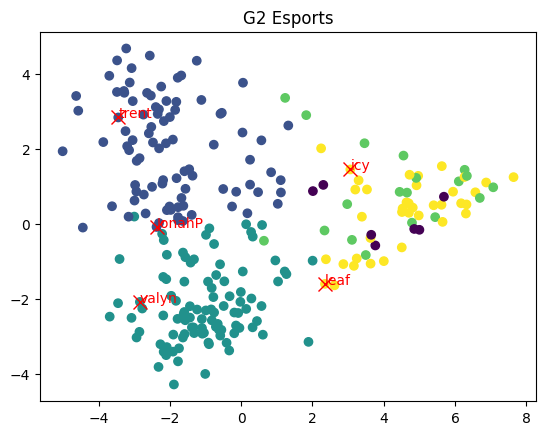

In [20]:
pcx = 0
pcy = 1
plt.clf()
plt.scatter(reduced_data[:, pcx], reduced_data[:, pcy], c=prop, cmap='viridis')
reset_id_df = agg_df.reset_index()
# print(reset_id_df.head())

target_team = 'G2 Esports'
names_i_care_about = man_teams[target_team]

plt.title(target_team)
if target_team != '':
    target_team_id = team_df.loc[team_df['name'] == target_team, 'id'].head(1).values
    if len(target_team_id) == 0:
        raise ValueError(f"No team found with name {target_team}")
    target_team_id = target_team_id[0]
    target_team_players_df = player_df.loc[player_df['home_team_id'] == target_team_id].drop_duplicates(subset='id').sort_values(by='updated_at', ascending=False)
    # print(target_team_players_df.head())
    # target_team_players = target_team_players_df.groupby('id').size().sort_values(ascending=False).reset_index()[['id']].values
    target_team_players = target_team_players_df[['id', 'handle']].values
    print(target_team_players)
    # print(reset_id_df.loc[reset_id_df['id'] == '108695564980340715'])

    target_team_player_idx = reset_id_df.loc[reset_id_df['id'].isin([p[0] for p in target_team_players])]
    target_player_dict = {p[0]:p[1] for p in target_team_players}
    # print(target_team_player_idx)
    for i, row in target_team_player_idx.iterrows():
        name = target_player_dict[row['id']]
        if name in names_i_care_about:
            x = reduced_data[i, pcx]
            y = reduced_data[i, pcy]
            print(name, x, y)
            plt.plot(x, y, 'rx', markersize=10)
            plt.annotate(name, (x, y), color='red')

### List of names, all pcas

106116521073981149 heat
106230316470125268 Lakia
106230370674623216 Crws
106651846714581139 qRaxs
106652148735956386 Chronicle
106724767436961366 d4v41
107735297326632949 trexx
107764993804063401 RieNs
107769215752919041 trent
107786689519485659 BeYN
107891889389481497 C0M
108284848458059527 nephh
108695559262017364 nobody 
109636696799297087 Hiro  
109795086166200353 AAAAY
109882303683541155 mta
110790632788902088 Biank
111878438452531105 heybay
112688316138301116 S1Mon
99566407765334300 Sacy
106116521073981149 heat
106230316470125268 Lakia
106230370674623216 Crws
106651846714581139 qRaxs
106652148735956386 Chronicle
106724767436961366 d4v41
107735297326632949 trexx
107764993804063401 RieNs
107769215752919041 trent
107786689519485659 BeYN
107891889389481497 C0M
108284848458059527 nephh
108695559262017364 nobody 
109636696799297087 Hiro  
109795086166200353 AAAAY
109882303683541155 mta
110790632788902088 Biank
111878438452531105 heybay
112688316138301116 S1Mon
99566407765334300 Sacy
10

<Figure size 640x480 with 0 Axes>

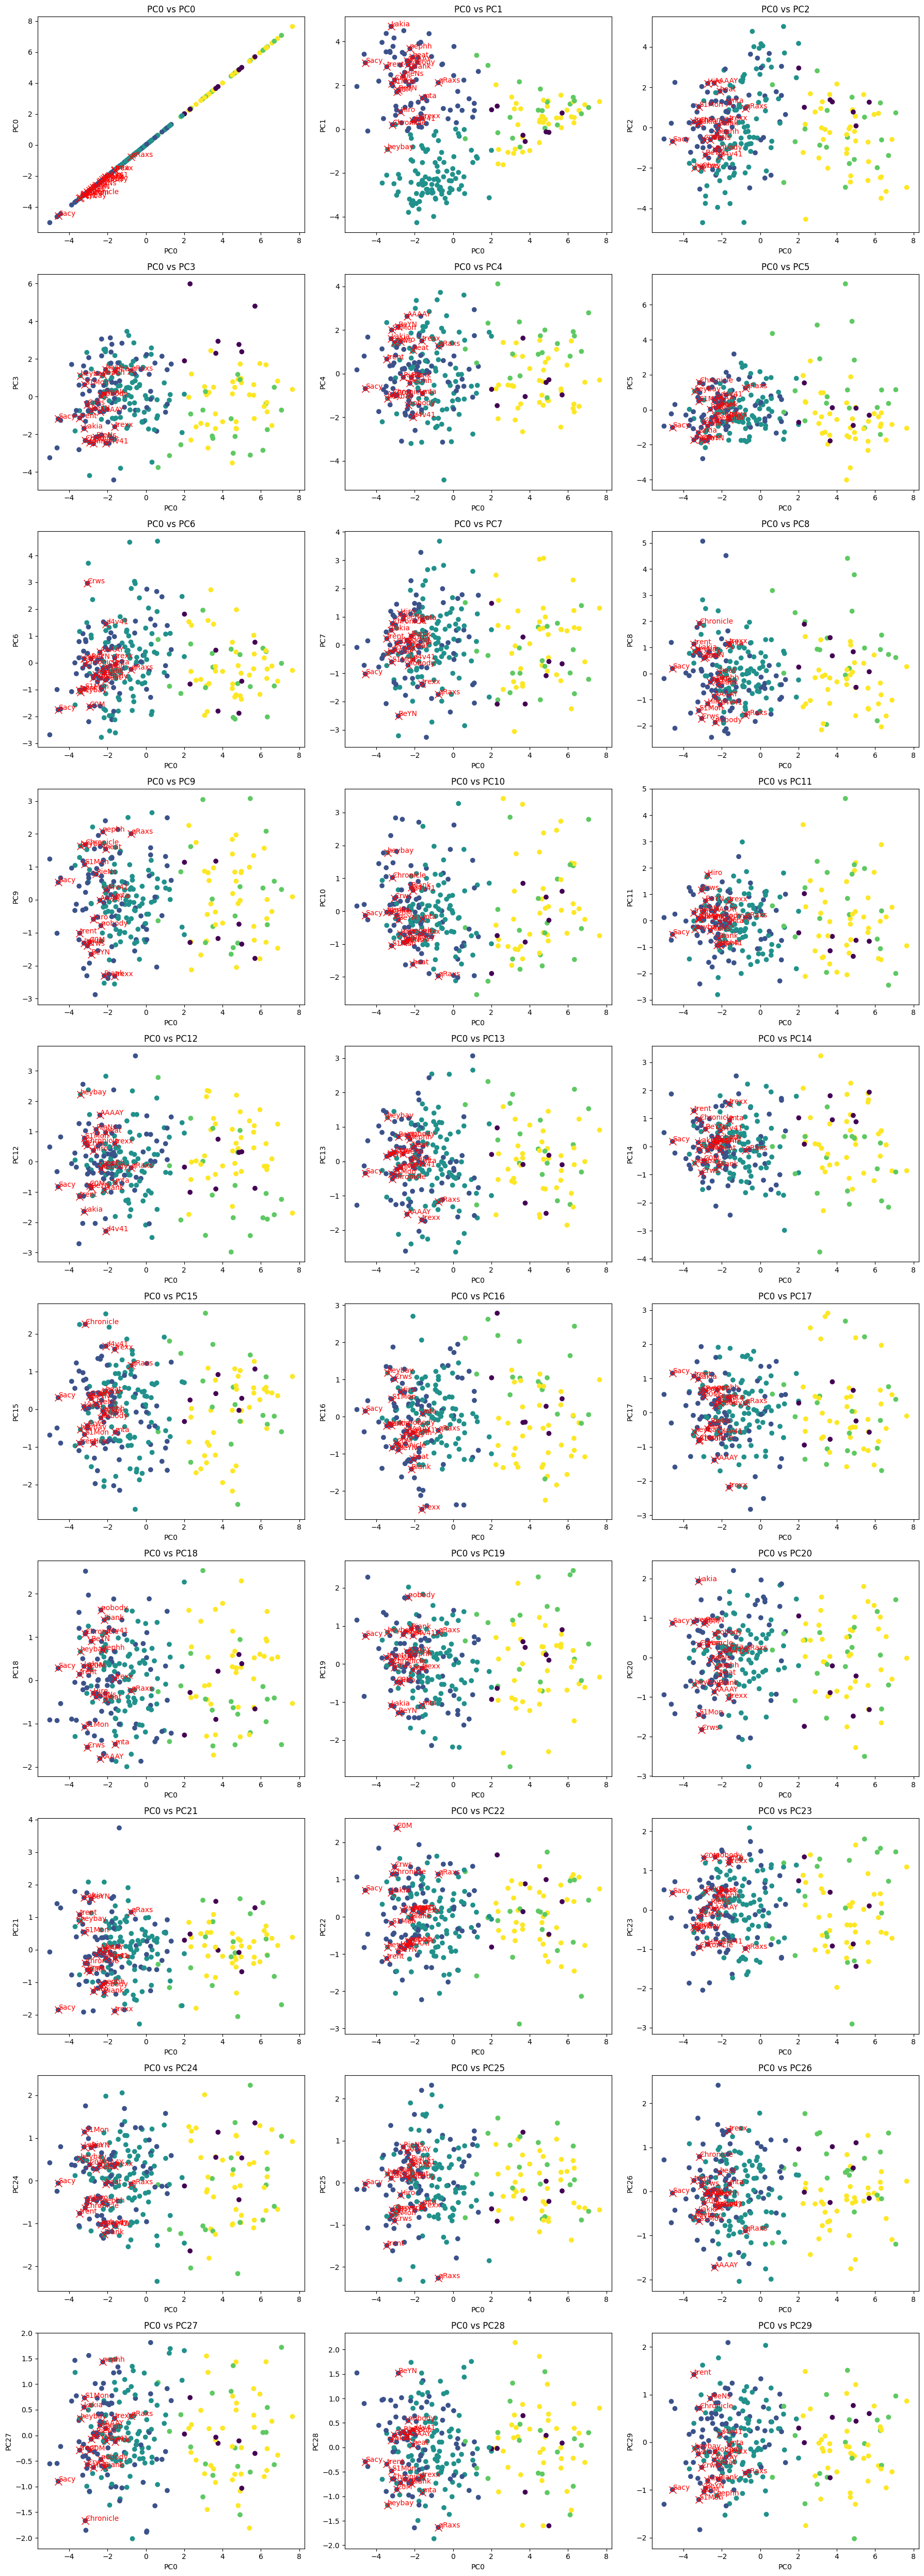

In [24]:
def create_multi_pca_plots(reduced_data, prop, agg_df, team_df, player_df, man_teams, target_team, pcy_list):
    reset_id_df = agg_df.reset_index()

    # Calculate the grid size
    n_plots = len(pcy_list)
    n_cols = min(3, n_plots)  # Max 3 columns
    n_rows = math.ceil(n_plots / n_cols)

    # Create the figure and subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows), squeeze=False)

    # Flatten the axs array for easier iteration
    axs_flat = axs.flatten()

    target_team_players_df = player_df.loc[player_df['handle'].isin(names_i_care_about)].drop_duplicates(subset='id').sort_values(by='updated_at', ascending=False)
    target_team_players = target_team_players_df[['id', 'handle']].values
    target_team_player_idx = reset_id_df.loc[reset_id_df['id'].isin([p[0] for p in target_team_players])]
    target_player_dict = {p[0]:p[1] for p in target_team_players}

    for idx, pcy in enumerate(pcy_list):
        ax = axs_flat[idx]

        # Create scatter plot
        scatter = ax.scatter(reduced_data[:, pcx], reduced_data[:, pcy], c=prop, cmap='viridis')

        ax.set_title(f"PC{pcx} vs PC{pcy}")
        ax.set_xlabel(f"PC{pcx}")
        ax.set_ylabel(f"PC{pcy}")

        if target_team != '':
            for i, row in target_team_player_idx.iterrows():
                name = target_player_dict[row['id']]
                print(row['id'], name)
                if name in names_i_care_about:
                    x = reduced_data[i, pcx]
                    y = reduced_data[i, pcy]
                    ax.plot(x, y, 'rx', markersize=10)
                    ax.annotate(name, (x, y), color='red')

    # Remove any unused subplots
    for idx in range(n_plots, len(axs_flat)):
        fig.delaxes(axs_flat[idx])

    plt.tight_layout()
    plt.show()

man_teams = {
    'Leviatán Esports': ['kiNgg', 'Mazino', 'aspas', 'tex', 'C0M',],
    'G2 Esports': ['JonahP', 'trent', 'valyn', 'leaf', 'icy',],
    'KRU Esports': ['Melser', 'keznitdeuS', 'Shyy', 'heat', 'mta',],
    'Sentinels' : ['zekken', 'Sacy', 'TenZ', 'johnqt', 'Zellsis',],
    'EDward Gaming' : ['CHICHOO', 'nobody ', 'ZmjjKK', 'Smoggy', 'S1Mon',],
    'FunPlus Phoenix' : ['AAAAY', 'BerLIN', 'Lysoar', 'Autumn ', 'Life2',],
    'Trace Esports' : ['FengF', 'heybay', 'Kai ', 'LuoK1ng', 'Biank',],
    'Bilibili Gaming' : ['whzy', 'Knightt', 'yosemite', 'nephh', 'Flex1n',],
    'FNATIC' : ['Boaster', 'Derke', 'Alfajer', 'Chronicle', 'Hiro  ',],
    'Team Vitality' : ['ceNder', 'runneR', 'Kicks', 'Sayf', 'trexx',],
    'Team Heretics' : ['Boo', 'benjyfishy', 'MiniBoo', 'RieNs', 'Wo0t',],
    'FUT Esports' : ['MrFaliN', 'qRaxs', 'ATA KAPTAN', 'yetujey', 'cNed',],
    'Gen.G Esports' : ['Meteor ', 't3xture', 'Lakia', 'Munchkin', 'Karon',],
    'DRX' : ['BuZz', 'MaKo', 'Foxy9', 'BeYN', 'Flashback',],
    'Paper Rex' : ['mindfreak', 'f0rsakeN', 'd4v41', 'something', 'Jinggg',],
    'Talon Esports' : ['Crws', 'JitBoyS', 'ban', 'Governor', 'Primmie',],
}

duelist = ['aspas', 'icy','keznitdeuS', 'zekken', 'ZmjjKK', 'Life2', 'FengF', 'whzy', 'Derke', 'Sayf', 'MiniBoo', 'cNed', 't3xture', 'BuZz', 'something', 'Jinggg','Primmie',]
sentinal = ['tex', 'leaf', 'Shyy', 'johnqt', 'CHICHOO', 'Lysoar', 'Kai ', 'yosemite', 'Alfajer', 'runneR', 'benjyfishy', 'yetujey', 'Meteor ', 'Foxy9', 'ban', ]
controller = ['kiNgg', 'valyn', 'Melser', 'TenZ', 'Smoggy', 'BerLIN', 'LuoK1ng', 'Boaster', 'ceNder', 'Boo', 'MrFaliN', 'Karon', 'MaKo', 'mindfreak', 'JitBoyS', 'ATA KAPTAN', ]
initiator = ['C0M', 'trent', 'heat', 'Sacy', 'nobody ', 'AAAAY', 'heybay', 'Biank', 'nephh', 'Chronicle', 'Hiro  ', 'trexx','RieNs', 'qRaxs', 'Lakia', 'BeYN', 'd4v41', 'Crws',  'mta', 'S1Mon',]
flex = ['Mazino', 'JonahP',  'mta', 'Zellsis', 'CHICHOO', 'Autumn ', 'Kai ', 'FengF', 'Knightt', 'Chronicle', 'Hiro  ', 'Sayf', 'Wo0t', 'MrFaliN', 'Munchkin', 'Flashback', 'f0rsakeN', 'Governor',]
igl = ['kiNgg', 'valyn', 'Melser', 'johnqt', 'nobody ', 'BerLIN', 'Boaster', 'ceNder', 'Boo', 'MrFaliN', 'nephh', 'Munchkin', 'MaKo', 'd4v41', 'Crws']

names_i_care_about = initiator

pcx = 0
pcy_list = list(range(29+1))  # Add the pcy values you want to plot
plt.clf()
create_multi_pca_plots(reduced_data, prop, agg_df, team_df, player_df, man_teams, target_team, pcy_list)

### single team, all pcas

<Figure size 640x480 with 0 Axes>

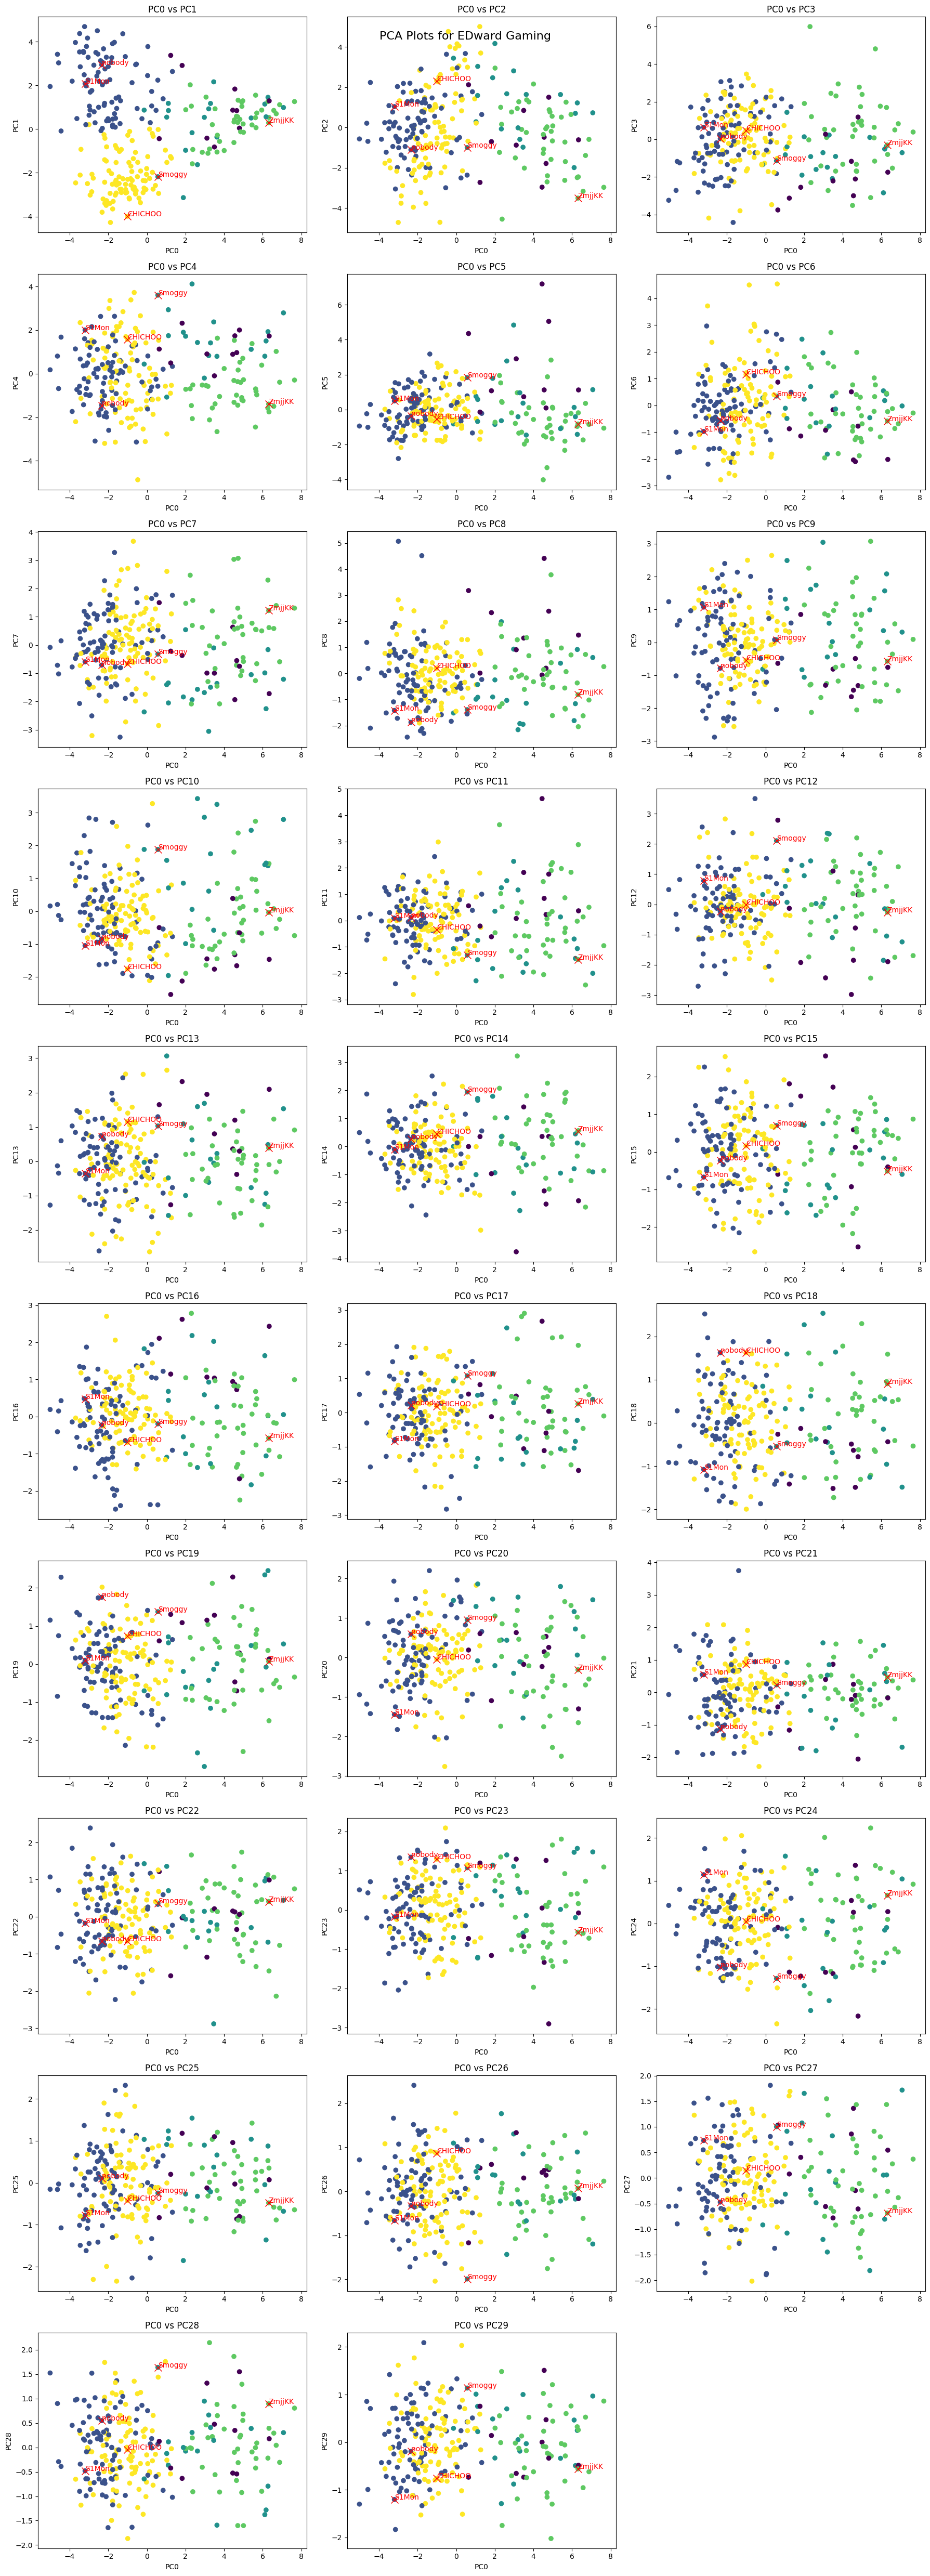

In [ ]:
def create_multi_pca_plots(reduced_data, prop, agg_df, team_df, player_df, man_teams, target_team, pcy_list):
    reset_id_df = agg_df.reset_index()
    names_i_care_about = man_teams[target_team]

    # Calculate the grid size
    n_plots = len(pcy_list)
    n_cols = min(3, n_plots)  # Max 3 columns
    n_rows = math.ceil(n_plots / n_cols)

    # Create the figure and subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows), squeeze=False)
    fig.suptitle(f"PCA Plots for {target_team}", fontsize=16)

    # Flatten the axs array for easier iteration
    axs_flat = axs.flatten()

    if target_team != '':
        target_team_id = team_df.loc[team_df['name'] == target_team, 'id'].head(1).values
        if len(target_team_id) == 0:
            raise ValueError(f"No team found with name {target_team}")
        target_team_id = target_team_id[0]
        target_team_players_df = player_df.loc[player_df['home_team_id'] == target_team_id].drop_duplicates(subset='id').sort_values(by='updated_at', ascending=False)
        target_team_players = target_team_players_df[['id', 'handle']].values
        target_team_player_idx = reset_id_df.loc[reset_id_df['id'].isin([p[0] for p in target_team_players])]
        target_player_dict = {p[0]:p[1] for p in target_team_players}

    for idx, pcy in enumerate(pcy_list):
        ax = axs_flat[idx]

        # Create scatter plot
        scatter = ax.scatter(reduced_data[:, pcx], reduced_data[:, pcy], c=prop, cmap='viridis')

        ax.set_title(f"PC{pcx} vs PC{pcy}")
        ax.set_xlabel(f"PC{pcx}")
        ax.set_ylabel(f"PC{pcy}")

        if target_team != '':
            for i, row in target_team_player_idx.iterrows():
                name = target_player_dict[row['id']]
                if name in names_i_care_about:
                    x = reduced_data[i, pcx]
                    y = reduced_data[i, pcy]
                    ax.plot(x, y, 'rx', markersize=10)
                    ax.annotate(name, (x, y), color='red')

    # Remove any unused subplots
    for idx in range(n_plots, len(axs_flat)):
        fig.delaxes(axs_flat[idx])

    plt.tight_layout()
    plt.show()

pcx = 0
target_team = 'EDward Gaming'
pcy_list = list(range(1, 29+1))  # Add the pcy values you want to plot
plt.clf()
create_multi_pca_plots(reduced_data, prop, agg_df, team_df, player_df, man_teams, target_team, pcy_list)

### all teams, one pca

Generated subplot for Leviatán Esports
Generated subplot for G2 Esports
Generated subplot for KRU Esports
Generated subplot for Sentinels
Generated subplot for EDward Gaming
Generated subplot for FunPlus Phoenix
Generated subplot for Trace Esports
Generated subplot for Bilibili Gaming
Generated subplot for FNATIC
Generated subplot for Team Vitality
Generated subplot for Team Heretics
Generated subplot for FUT Esports
Generated subplot for Gen.G Esports
Generated subplot for DRX
Generated subplot for Paper Rex
Generated subplot for Talon Esports
Combined plot has been generated


<Figure size 640x480 with 0 Axes>

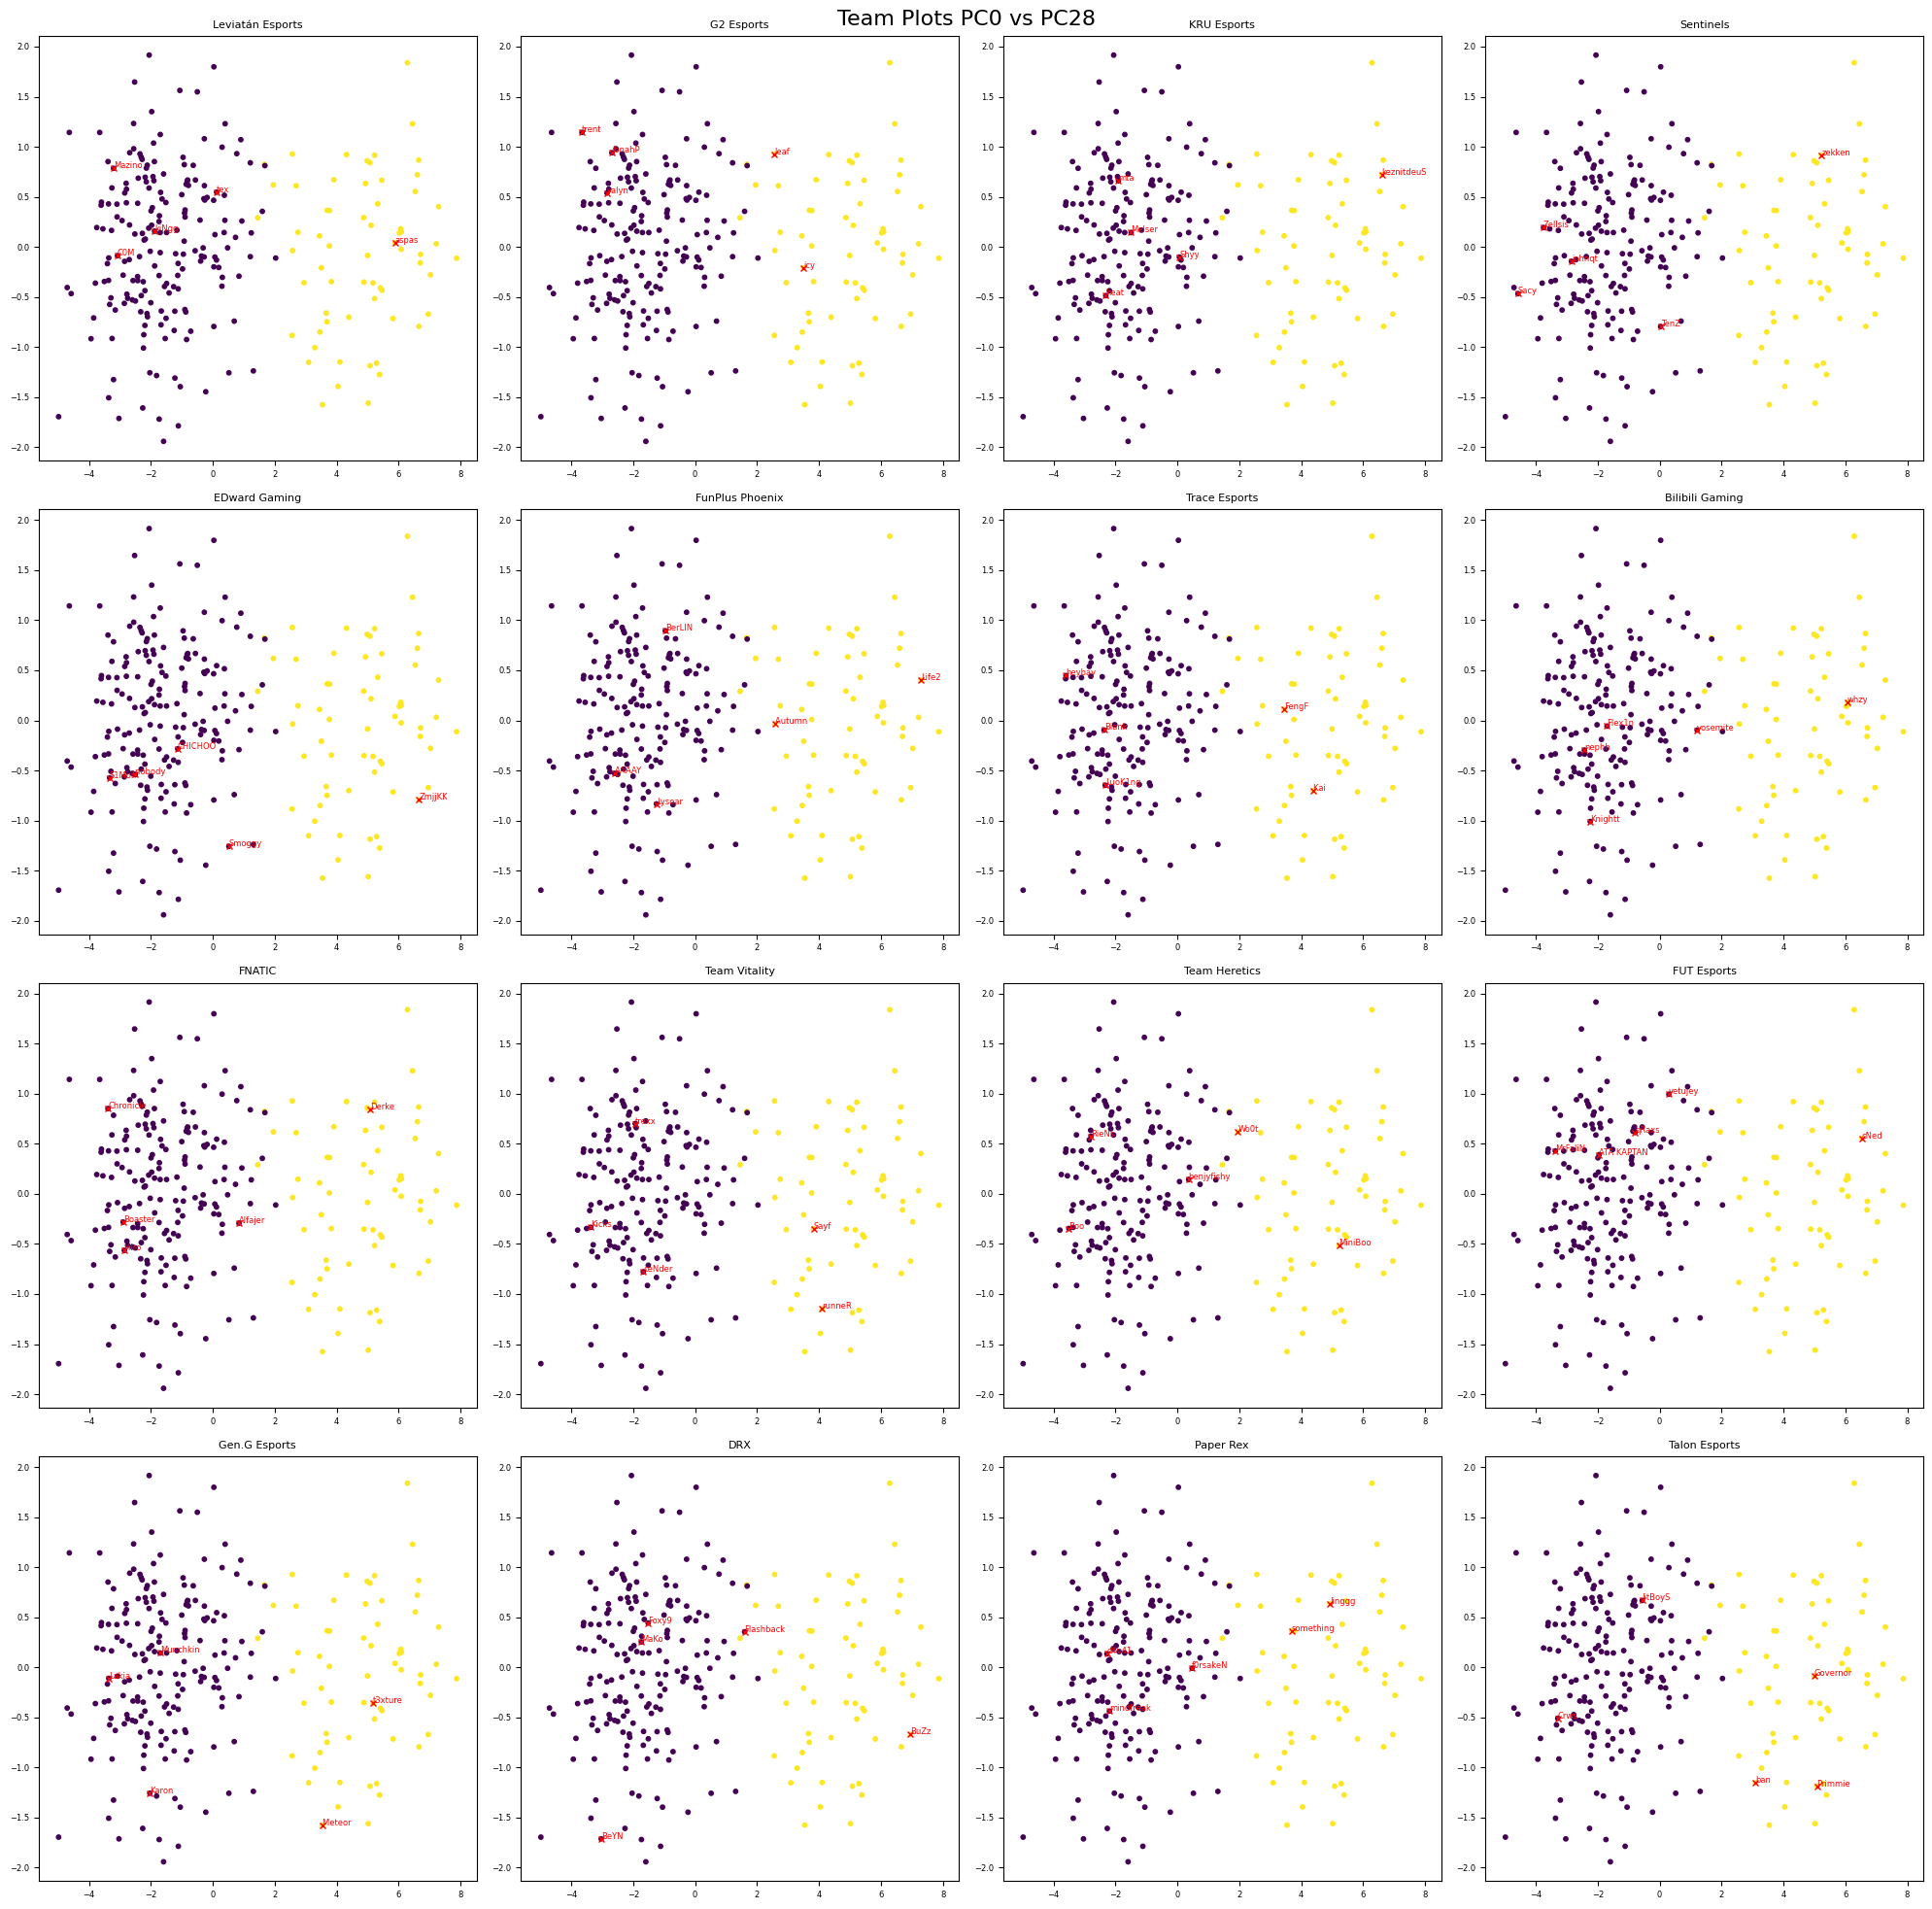

In [ ]:
def generate_team_subplot(ax, team_name, man_teams, reduced_data, prop, reset_id_df, team_df, player_df):
    ax.scatter(reduced_data[:, pcx], reduced_data[:, pcy], c=prop, cmap='viridis', s=10)

    ax.set_title(team_name, fontsize=8)
    names_i_care_about = man_teams[team_name]

    target_team_id = team_df.loc[team_df['name'] == team_name, 'id'].head(1).values
    if len(target_team_id) == 0:
        print(f"No team found with name {team_name}")
        return
    target_team_id = target_team_id[0]

    target_team_players_df = player_df.loc[player_df['home_team_id'] == target_team_id].drop_duplicates(subset='id').sort_values(by='updated_at', ascending=False)
    target_team_players = target_team_players_df[['id', 'handle']].values

    target_team_player_idx = reset_id_df.loc[reset_id_df['id'].isin([p[0] for p in target_team_players])]
    target_player_dict = {p[0]:p[1] for p in target_team_players}

    for i, row in target_team_player_idx.iterrows():
        name = target_player_dict[row['id']]
        if name in names_i_care_about:
            ax.plot(reduced_data[i, pcx], reduced_data[i, pcy], 'rx', markersize=5)
            ax.annotate(name, (reduced_data[i, pcx], reduced_data[i, pcy]), color='red', fontsize=6)

    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.tick_params(axis='both', which='minor', labelsize=4)

pcx = 0
pcy = 28

# Main execution
num_teams = len(man_teams)
cols = 4  # You can adjust this to change the number of columns
rows = math.ceil(num_teams / cols)

plt.clf()
fig, axs = plt.subplots(rows, cols, figsize=(20, 5*rows))
fig.suptitle(f'Team Plots PC{pcx} vs PC{pcy}', fontsize=16)

for idx, (team_name, ax) in enumerate(zip(man_teams.keys(), axs.flatten())):
    generate_team_subplot(ax, team_name, man_teams, reduced_data, prop, reset_id_df, team_df, player_df)
    print(f"Generated subplot for {team_name}")

# Remove any unused subplots
for idx in range(num_teams, rows*cols):
    fig.delaxes(axs.flatten()[idx])

plt.tight_layout()
#plt.savefig("all_teams_plot.png", dpi=300, bbox_inches='tight')
#plt.close()

print("Combined plot has been generated")

### Misc

In [ ]:
df.loc[df['id'] == '108695564980340715'].head()

ROUND_NUMBER  OUTCOME  SIDE  KILLS  DEATHS  ASSISTS  COMBAT_SCORE  \
9            1.0      1.0   1.0    2.0     1.0      1.0         447.0   
19           2.0      1.0   1.0    0.0     1.0      0.0           0.0   
29           3.0      1.0   1.0    0.0     0.0      3.0          75.0   
39           4.0      1.0   1.0    0.0     0.0      0.0          24.0   
49           5.0      1.0   1.0    1.0     0.0      0.0         117.0   

    KILLS_STINGER  KILLS_BUCKY  KILLS_JUDGE  ...  YORU_PICK_RATE  \
9             0.0          0.0          0.0  ...             0.0   
19            0.0          0.0          0.0  ...             0.0   
29            0.0          0.0          0.0  ...             0.0   
39            0.0          0.0          0.0  ...             0.0   
49            0.0          0.0          0.0  ...             0.0   

    ISO_PICK_RATE  CLOVE_PICK_RATE  VYSE_PICK_RATE  DUELIST_PICK_RATE  \
9             0.0              1.0             0.0                0.0   
19            0.0              1.0             0.0                0.0   
29            0.0              1.0             0.0                0.0   
39            0.0              1.0             0.0                0.0   
49            0.0              1.0             0.0                0.0   

    INITIATOR_PICK_RATE  SENTINEL_PICK_RATE  CONTROLLER_PICK_RATE  \
9                   0.0                 0.0                   1.0   
19                  0.0                 0.0                   1.0   
29                  0.0                 0.0                   1.0   
39                  0.0                 0.0                   1.0   
49                  0.0                 0.0                   1.0   

                    id                                           metadata  
9   108695564980340715  {map=LOTUS, game_id=val:81f50f37-70a2-4328-a81...  
19  108695564980340715  {map=LOTUS, game_id=val:81f50f37-70a2-4328-a81...  
29  108695564980340715  {map=LOTUS, game_id=val:81f50f37-70a2-4328-a81...  
39  108695564980340715  {map=LOTUS, game_id=val:81f50f37-70a2-4328-a81...  
49  108695564980340715  {map=LOTUS, game_id=val:81f50f37-70a2-4328-a81...  

[5 rows x 63 columns]

In [ ]:
print(max(reduced_data[:, 0]))
print(np.where(reduced_data[:, 0] == 71.43064162120518)[0][0])
print(agg_df.iloc[202])

player_df.loc[player_df['id'] == '109782814170794767']

71.43064162120518
202
ROUND_NUMBER            34.000000
OUTCOME                 -0.043796
SIDE                    -0.041363
KILLS                    0.901460
DEATHS                   0.806569
                          ...    
VYSE_PICK_RATE           0.000000
DUELIST_PICK_RATE        1.000000
INITIATOR_PICK_RATE      0.000000
SENTINEL_PICK_RATE       0.000000
CONTROLLER_PICK_RATE     0.000000
Name: 109782814170794767, Length: 61, dtype: float64


id handle first_name last_name  status  \
809   109782814170794767    OXY    Francis     Hoang  active   
2347  109782814170794767    Oxy    Francis     Hoang  active   
2459  109782814170794767    OXY    Francis     Hoang  active   
2591  109782814170794767    Oxy    Francis     Hoang  active   
2662  109782814170794767    OXY    Francis     Hoang  active   
2745  109782814170794767    Oxy    Francis     Hoang  active   
3110  109782814170794767    Oxy   Francis      Hoang  active   

                                              photo_url        home_team_id  \
809   http://static.lolesports.com/players/170717470...  106013968992887532   
2347                                               None  105680891295502820   
2459                                               None  106013968992887532   
2591                                               None  106013968992887532   
2662  http://static.lolesports.com/players/170717470...  106013968992887532   
2745                                               None  105680891295502820   
3110                                               None  105680891295502820   

                created_at            updated_at  
809   2024-02-05T23:11:48Z  2024-04-10T07:40:12Z  
2347  2023-06-06T01:50:08Z  2023-09-26T07:53:08Z  
2459  2023-09-26T07:58:43Z  2024-02-05T23:11:48Z  
2591  2023-09-26T07:53:08Z  2023-09-26T07:58:43Z  
2662  2024-04-10T07:40:12Z  2024-04-10T07:40:12Z  
2745  2023-01-31T08:58:02Z  2023-06-06T01:50:07Z  
3110  2023-06-06T01:50:07Z  2023-06-06T01:50:08Z

In [ ]:
player_pca.components_

array([[ 2.32101109e-02,  5.94109301e-04, -1.40349170e-04,
         3.17364752e-03,  4.74079413e-04, -1.29221514e-03,
         8.96812476e-01,  2.05469728e-05,  1.29115229e-05,
         2.64117844e-05, -4.12626240e-05, -7.15232322e-05,
         1.06834382e-04,  3.34434623e-05,  1.38835524e-03,
         8.22364503e-05,  1.65878174e-04,  6.31175656e-04,
        -5.79503050e-06, -1.17333016e-04, -7.78465070e-05,
         4.43424426e-05,  2.59572345e-05,  2.18511275e-04,
         1.24845341e-04, -2.73220270e-06, -4.82081026e-02,
         4.59559819e-04,  8.83390102e-02,  4.29995634e-01,
        -9.06817301e-04, -6.21891693e-04, -1.60181181e-04,
        -7.61074101e-04, -8.38754501e-05,  1.77314939e-04,
        -6.61823490e-04, -3.69304012e-05, -5.93792599e-04,
        -2.24335197e-04, -9.73487021e-05,  3.36101081e-03,
         0.00000000e+00, -3.72696938e-04,  8.87969707e-04,
        -1.79453476e-03,  8.42565642e-05,  3.98824541e-03,
         1.16107253e-04, -4.97769203e-05, -3.96299597e-0